# import libraries

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  # for graphics

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input # Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam # SGD, RMSprop, 

from sklearn.model_selection import train_test_split
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score

from gensim.models import FastText, KeyedVectors  # train w2v : Word2Vec

import time # for time execution

import os # for checking the file exists or not

import yaml  # for configuration parameters


In [70]:
##########################################
# Goal: Create a word vector or word embedding, with gensim, Word2vec, FastText
# Source: https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c
##########################################
#  == Strategie==
# word embeddings files => load model => convert text data to digital data
# => divide dataset into train, test => Feed training data into Mahine Learning Classifier and train clasiffier
# => Predictions (testing) => output results
# option: FastText
def create_w2v_faster(text, cheminModele, cheminVocab, embSize=100):
    #cheminModele = "./models/fasttext_gensim.vec"
    #cheminVocab = "./models/fasttext_gensim.vocab"
    
    # train
    model = FastText(text, size=embSize, window=5, min_count=1, sg=1, negative=5, hs =0)
    
    # save model
    model.wv.save_word2vec_format(cheminModele, cheminVocab, binary=False)


# class SentenceGetter allows to deal with sentences from raw data
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        
        # with 2 columns: Word - Tag
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        
        # with 3 columns: Word - POS -  Tag
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),  # add the POS column, by Tan, 17042019
                                                           s["Tag"].values.tolist())]
        
        
        
        
        # error: # bi loi cau thu 8 ???? ko lay lai data trung khop voi output_format.txt 
        # solution :: rajouter cette option sort=False dans groupby... garder l ordre du dataframe        
        #self.grouped = self.data.groupby("Sentence #").apply(agg_func)   # old version
        self.grouped = self.data.groupby("Sentence #", sort=False).apply(agg_func)  # new version

        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [119]:
#########################################
# set parameters:
config = yaml.safe_load(open('HyperParameters.yml'))   # all hyper-parameters
#print(config['max_len'])  # display : maxlen = 50

np.random.seed(42)  # for reproducibility

path_absolute_source = config['path_absolute_source']
path_absolute_target = config['path_absolute_target']
path_emb_model = config['path_emb_model']
path_emb_model_vocab = config['path_emb_model_vocab']
path_model_source = config["path_model_source"]
path_model_target = config["path_model_target"]

flag_embed_trainable = config['flag_embed_trainable'] # embedding trainable=False or True
flag_option_target_model = config['flag_option_target_model']  # 0: 1 FC only (by default), 1: 1 Dense + 1 FC, 2: 1 BiLSTM + 1 FC
flag_option_experiment = config['flag_option_experiment'] # 0: Extracter Features, 1: Fine Tuning

max_features = config['max_features'] # txt_vocab
max_len = config['max_len'] #50 #400  # txt_max_sent_len
batch_size = config['batch_size'] #10
embedding_dims = config['embedding_dims'] #50 #100 #200
hidden_dims = config['hidden_dims'] #100
nb_epoch_source = config['nb_epoch_source'] # iteration for the base source model
nb_epoch_target = config['nb_epoch_target'] # more iteration for the target model
val_split = config['val_split'] #0.10, training set = 90%, val set = 10%
dropout_prob = config['dropout_prob'] #0.20 # seuil pour y_preds
#########################################

# Step 1: Input, loading data

In [7]:
print("\n>>> 1. Loading data...")

data = pd.read_csv(path_absolute_source, delimiter='\t',
                   header=None, 
                   encoding='utf-8', 
                   quoting=3  # means QUOTE_NONE
                   )

data = data.rename(columns={0:'Sentence #', 1:'Word', 2: 'POS', 3: 'Tag'}) #.drop_duplicates()

data.info()
data.tail(10)


>>> 1. Loading data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696053 entries, 0 to 696052
Data columns (total 4 columns):
Sentence #    696053 non-null object
Word          696053 non-null object
POS           696053 non-null object
Tag           696053 non-null object
dtypes: object(4)
memory usage: 21.2+ MB


,Sentence #,Word,POS,Tag
696043,Sentence: 27363,은,JXT,I
696044,Sentence: 27363,거의,MAG,O
696045,Sentence: 27363,일본,NQ,B
696046,Sentence: 27363,에서,JCA,I
696047,Sentence: 27363,수입,NCPA,B
696048,Sentence: 27363,하,XSV,I
696049,Sentence: 27363,고,ECX,I
696050,Sentence: 27363,있,PX,B
696051,Sentence: 27363,다,EF,I
696052,Sentence: 27363,.,SF,O


# Step 2: Process 


In [8]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

# vocabulary size
n_words = len(words)
print("#words = ", n_words)    
max_features = n_words
      
# all tags 
tags = list(set(data["Tag"].values))    
n_tags = len(tags)
print("#tags = ", n_tags)   #  3 tags
print("tags = ", tags)     # ['B', 'I', 'O']

#words =  29058
#tags =  3
tags =  ['I', 'O', 'B']


In [9]:
# to call the class SentenceGetter to get sentences
getter = SentenceGetter(data)
sent = getter.get_next()
print("1 sentence looks like : " , sent)

# to regroup all sentences
sentences = getter.sentences
print(sentences[0])
print("#sentences = ", len(sentences))  

1 sentence looks like :  [('하기야', 'MAJ', 'O'), ('짐승', 'NCN', 'B'), ('도', 'JXC', 'I'), ('잘', 'MAG', 'O'), ('가르치', 'PVG', 'B'), ('기', 'ETN', 'I'), ('만', 'JXC', 'I'), ('하', 'PVG', 'B'), ('면', 'ECS', 'I'), ('어느', 'MMD', 'O'), ('정도', 'NCN', 'B'), ('는', 'JXT', 'I'), ('순치', 'NCPA', 'B'), ('되', 'XSV', 'I'), ('ㄹ', 'ETM', 'I'), ('수', 'NBN', 'O'), ('있', 'PAA', 'B'), ('다', 'EF', 'I'), ('.', 'SF', 'O')]
[('하기야', 'MAJ', 'O'), ('짐승', 'NCN', 'B'), ('도', 'JXC', 'I'), ('잘', 'MAG', 'O'), ('가르치', 'PVG', 'B'), ('기', 'ETN', 'I'), ('만', 'JXC', 'I'), ('하', 'PVG', 'B'), ('면', 'ECS', 'I'), ('어느', 'MMD', 'O'), ('정도', 'NCN', 'B'), ('는', 'JXT', 'I'), ('순치', 'NCPA', 'B'), ('되', 'XSV', 'I'), ('ㄹ', 'ETM', 'I'), ('수', 'NBN', 'O'), ('있', 'PAA', 'B'), ('다', 'EF', 'I'), ('.', 'SF', 'O')]
#sentences =  27363


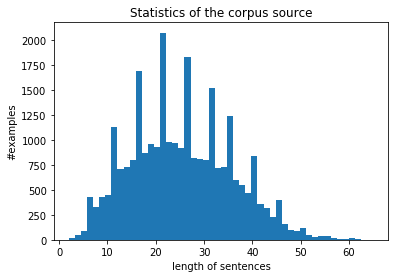

In [10]:
# visualize with graphics
plt.hist([len(s) for s in sentences], bins=50)
plt.title("Statistics of the corpus source")
plt.xlabel('length of sentences')
plt.ylabel('#examples')
#plt.show()
plt.savefig('./outputs/Graphic_All_Length_Sentences_Whole_Corpus_Source.png')

In [11]:
"""
#For the use of neural nets (at least with keras, this is no theoretical reason) 
#we need to use equal-lenght input sequences. So we are going to pad our sentences
# to a length of 80. But first we need dictionaries of words and tags.
"""
# Training the model
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print("tag2idx : ", tag2idx)  # tag2idx :  {'I': 0, 'O': 1, 'B': 2}

tag2idx :  {'I': 0, 'O': 1, 'B': 2}


In [12]:
# Add by Tan, mercredi 10/07/2019
# list of sentences, w,p,t = word, pos_tag, bio_tag
comments = [[w for w,p,t in s] for s in sentences] 

In [13]:
# option FastText embedding
# call function to create a word embedding
print("\n>>> Creating a word vector with gensim...")

# check if the file does not exist then train w2v with gensim
# else load the w2v model 
if os.path.isfile(path_emb_model) == False:  
    create_w2v_faster(comments, path_emb_model, path_emb_model_vocab, 50)  
    print('\n...saved to file path: ' + path_emb_model)   
else:
    print("\n>>> Loading the pretrained word vector with gensim...")
    print('... from the file path ' + path_emb_model)
    model_w2v = KeyedVectors.load_word2vec_format(path_emb_model, binary=False)  # C text format

print("\n...done...")


>>> Creating a word vector with gensim...

>>> Loading the pretrained word vector with gensim...
... from the file path ./models/fasttext_gensim.vec

...done...


In [14]:
print("\n>>> Testing the most_similar")
w = model_w2v['중국']
print("\n... shape of China : ")
print(w.shape)
print("\n... the 10 first similar words of China : ")
print("\t 중국...")
print(model_w2v.most_similar('중국')) 


>>> Testing the most_similar

... shape of China : 
(50,)

... the 10 first similar words of China : 
	 중국...
[('북중국', 0.8661185503005981), ('중국측', 0.8657894134521484), ('제국', 0.8544776439666748), ('중국어', 0.8408035039901733), ('침략', 0.8338326215744019), ('서역', 0.8323560953140259), ('소련', 0.8288898468017578), ('중국제', 0.8267003893852234), ('북방', 0.8230296969413757), ('훈', 0.8213281035423279)]


In [15]:
# Preparing the embedding matrix
embeddings_index = {}  # type: dict()

# open the word2vec file
f = open(path_emb_model, encoding='utf-8')

# loop each line in the word2vec file
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

# close the word2vec file
f.close()

print('\n>>> Found %s word vectors.' % len(embeddings_index))


>>> Found 29058 word vectors.


In [17]:
# tokenization with keras.preprocessing.text
MAX_NB_WORDS = n_words
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

word_index = tokenizer.word_index  # dictionary: (key, value) = (token, number)
print('\n>>> Found %s unique tokens.' % len(word_index))


>>> Found 29043 unique tokens.


In [18]:
# embedding initializing
EMBEDDING_DIM = max_len # 50 by default, 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [19]:
# After creating of the embedding matrix, to need to pad_sequences of train,test,dev
X = [[word_index.get(w[0],0) for w in s] for s in sentences] # list of sentences (<= list of words) = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1) 

# tag = label
y = [[tag2idx[w[2]] for w in s] for s in sentences]    
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

# For training the network we also need to change the labels y to categorial
y = [to_categorical(i, num_classes=n_tags) for i in y]

# We split in train, test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_split)

print("\n>>> Length of X_train %d, X_test %d" % (len(X_train), len(X_test)))


>>> Length of X_train 24626, X_test 2737


## Create the base source model 

In [120]:
# Architecture of the base source model
txt_input = Input(shape=(max_len,), name='input')

# without the embedding matrix
#model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)

# with the embedding matrix
wv_layer = Embedding(len(word_index)+1,   # or n_words or MAX_NB_WORDS
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     name='word_embedding',
                     trainable=flag_embed_trainable  #False  # True
                     )

model = wv_layer(txt_input)
model = Dropout(dropout_prob, name='word_dropout')(model)
model = Bidirectional(LSTM(units=hidden_dims, return_sequences=True, 
                           recurrent_dropout=dropout_prob), 
                        name='biLSTM')(model)
output = TimeDistributed(Dense(n_tags, activation="softmax"),
                         name='fc_output_layer')(model)  # softmax output layer

# creating the architecture of the base source model
source_model = Model(txt_input, output)

# summary the base source model
source_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 50)            1452200   
_________________________________________________________________
word_dropout (Dropout)       (None, 50, 50)            0         
_________________________________________________________________
biLSTM (Bidirectional)       (None, 50, 200)           120800    
_________________________________________________________________
fc_output_layer (TimeDistrib (None, 50, 3)             603       
Total params: 1,573,603
Trainable params: 1,573,603
Non-trainable params: 0
_________________________________________________________________


In [21]:
# compile the base source model 
source_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

# create the checkpoint
checkpoint = ModelCheckpoint(path_model_source,
                              monitor='val_acc', 
                              verbose=2, 
                              save_best_only=True,
                              mode='max')

In [61]:
# time execution
start_time_source = time.time()   # now()

## (1) Train the neural network model
history = source_model.fit(X_train, np.array(y_train), 
                           batch_size=batch_size, 
                           epochs=nb_epoch_source, 
                           callbacks=[checkpoint],
                           validation_split=val_split, 
                           verbose=2)  #1

# time execution
stop_time_source = time.time() - start_time_source
print('\n>>> Training time for the base source model: %s seconds' % stop_time_source)

Train on 22163 samples, validate on 2463 samples
Epoch 1/10
 - 8s - loss: 0.0576 - acc: 0.9783 - val_loss: 0.0461 - val_acc: 0.9813
Epoch 2/10
 - 8s - loss: 0.0379 - acc: 0.9850 - val_loss: 0.0421 - val_acc: 0.9827
Epoch 3/10
 - 8s - loss: 0.0344 - acc: 0.9864 - val_loss: 0.0410 - val_acc: 0.9834
Epoch 4/10
 - 8s - loss: 0.0321 - acc: 0.9873 - val_loss: 0.0403 - val_acc: 0.9836
Epoch 5/10
 - 8s - loss: 0.0303 - acc: 0.9882 - val_loss: 0.0400 - val_acc: 0.9840
Epoch 6/10
 - 8s - loss: 0.0293 - acc: 0.9885 - val_loss: 0.0402 - val_acc: 0.9840
Epoch 7/10
 - 8s - loss: 0.0281 - acc: 0.9890 - val_loss: 0.0396 - val_acc: 0.9842
Epoch 8/10
 - 8s - loss: 0.0273 - acc: 0.9893 - val_loss: 0.0395 - val_acc: 0.9845
Epoch 9/10
 - 8s - loss: 0.0265 - acc: 0.9897 - val_loss: 0.0392 - val_acc: 0.9842
Epoch 10/10
 - 8s - loss: 0.0254 - acc: 0.9901 - val_loss: 0.0400 - val_acc: 0.9842

>>> Training time for the base source model: 81.58758306503296 seconds


In [23]:
# serialize weights to HDF5
print("\n>>> Saved model to disk")
source_model.save_weights(path_model_source)
print('\n...saved to file path: ' + path_model_source)
print("\n...done")


>>> Saved model to disk

...saved to file path: ./models/weights_lstm_ko_kaist.hdf5

...done


## Evaluate the base source model 

In [24]:
best_val_acc_source = max(history.history['val_acc'])
print("\n>>> Best value accuracy: {:.2%}".format(best_val_acc_source))


>>> Best value accuracy: 98.35%


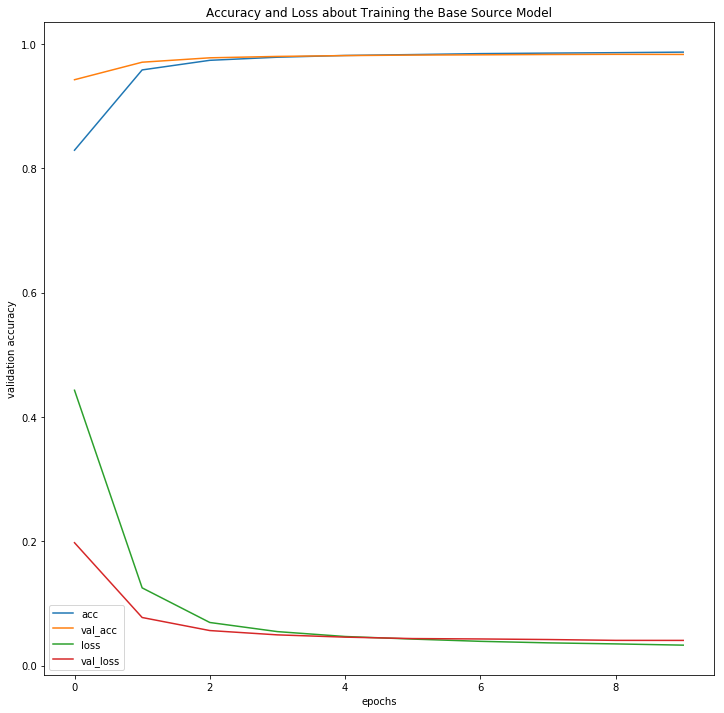

In [25]:
# visualize with graphics
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend()
plt.title('Accuracy and Loss about Training the Base Source Model')
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.savefig('./outputs/Graphic_Val_accuracy_Training_Model_Source.png')       # for history
# plt.show()

In [85]:
print('\n>>> Make prediction of classes from the base source model')
test_preds = source_model.predict(X_test, verbose=2) # 1

idx2tag = {i: w for w, i in tag2idx.items()}

# function to convert the prediction to label BIO
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
#            out_i.append(idx2tag[p_i].replace("PAD", " ")) # by Tan, lundi 08/04/2019
        out.append(out_i)
    return out

# to convert prediction and test labels
pred_labels = pred2label(test_preds)
test_labels = pred2label(y_test)


>>> Make prediction of classes from the base source model


In [86]:
print("\n>>> F1-score: {:.2%}".format(flat_f1_score(test_labels, pred_labels, average='weighted')))


>>> F1-score: 98.51%


In [87]:
print('\n>>> Classification Report:\n')
print(flat_classification_report(test_labels, pred_labels))


>>> Classification Report:

              precision    recall  f1-score   support

           B       0.96      0.97      0.96     24696
           I       0.98      0.99      0.98     34845
           O       1.00      0.99      0.99     77309

   micro avg       0.99      0.99      0.99    136850
   macro avg       0.98      0.98      0.98    136850
weighted avg       0.99      0.99      0.99    136850



## Create the target model 

In [29]:
# prepare a new dataset (train, dev, test), e.g. ko_gsd_all.conllu.txt
data_new = pd.read_csv(path_absolute_target,
                       delimiter='\t',header=None,
                       encoding='utf-8', 
                       quoting=3  # means QUOTE_NONE
                       )
# engine='python', encoding='utf-8'
# error_bad_lines=False
# Source: https://stackoverflow.com/questions/18016037/pandas-parsererror-eof-character-when-reading-multiple-csv-files-to-hdf5
# I had a similar problem. 
#The line listed with the 'EOF inside string' had a string that 
#contained within it a single quote mark. 
#When I added the option quoting=csv.QUOTE_NONE it fixed my problem.
#csv.QUOTE_NONE means that quotes are never placed around fields.

data_new = data_new.rename(columns={0:'Sentence #', 1:'Word', 2: 'POS', 3: 'Tag'}) #.drop_duplicates()

In [91]:
words_new = list(set(data_new["Word"].values))
words_new.append("ENDPAD")

# target new vocabulary size
n_words_new = len(words_new)
max_features = n_words_new      # update the max_features or txt_vocab_size

# all new target tags 
tags_new = list(set(data_new["Tag"].values))
n_tags_new = len(tags_new)
print("#new_tags = ", n_tags_new)   #  4 tags
print("new tags = ", tags_new)     # ['S', 'B', 'E', 'I']

#new_tags =  3
new tags =  ['I', 'O', 'B']


In [31]:
# to call the class SentenceGetter to get sentences
getter_new = SentenceGetter(data_new)
sent_new = getter.get_next()

print("\n1 sentence looks like : " , sent_new)

# to regroup all sentences
sentences_new = getter_new.sentences
print(sentences_new[0])
print("\n#new_sentences = ", len(sentences_new))


1 sentence looks like :  [('사람', 'NCN', 'B'), ('이', 'JCS', 'I'), ('스스로', 'MAG', 'O'), ('만물', 'NCN', 'B'), ('의', 'JCM', 'I'), ('영장', 'NCN', 'B'), ('이', 'JP', 'I'), ('라', 'ECS', 'I'), ('하', 'PVG', 'B'), ('고', 'ECS', 'I'), ('우쭐대', 'PVG', 'B'), ('는', 'ETM', 'I'), ('까닭', 'NCN', 'B'), ('이', 'JCS', 'I'), ('여기', 'NPD', 'B'), ('에', 'JCA', 'I'), ('있', 'PAA', 'B'), ('다', 'EF', 'I'), ('.', 'SF', 'O')]
[('잡스', 'NNP', 'B'), ('는', 'JX', 'I'), ('워즈니악', 'NNP', 'B'), ('에게', 'JKB', 'I'), ('보수', 'NNG', 'B'), ('를', 'JKO', 'I'), ('반', 'NNG', 'B'), ('씩', 'XSN', 'I'), ('나누', 'VV', 'B'), ('는', 'ETM', 'I'), ('조건', 'NNG', 'B'), ('으로', 'JKB', 'I'), ('도움', 'NNG', 'B'), ('을', 'JKO', 'I'), ('청', 'NNG', 'B'), ('하', 'XSV', 'I'), ('고', 'EC', 'I'), ('워즈니악', 'NNP', 'B'), ('은', 'JX', 'I'), ('불과', 'MAG', 'O'), ('4', 'SN', 'B'), ('일만', 'NR', 'I'), ('에', 'JKB', 'I'), ('45', 'SN', 'B'), ('개', 'NNB', 'I'), ('의', 'JKG', 'I'), ('칩', 'NNG', 'B'), ('만', 'JX', 'I'), ('으로', 'JKB', 'I'), ('게임', 'NNG', 'B'), ('을', 'JKO', 'I'), ('설계',

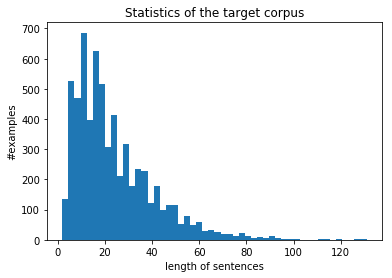

In [32]:
# visualize with graphics
plt.hist([len(s) for s in sentences_new], bins=50)
plt.title("Statistics of the target corpus")
plt.xlabel('length of sentences')
plt.ylabel('#examples')
#plt.show()
plt.savefig('./outputs/Graphic_All_Length_Sentences_Whole_Corpus_Target.png')

In [90]:
# Preparing the training data for the target model
word2idx_new = {w: i for i, w in enumerate(words_new)}
tag2idx_new = {t: i for i, t in enumerate(tags_new)}
# tag2idx_new = tag2idx

print("new tag2idx : ", tag2idx_new)    # tag2idx  i.e. {'B': 0, 'I': 1, 'O': 2}
print("old tag2idx : ", tag2idx)        # tag2idx  i.e. {'B': 0, 'I': 1, 'O': 2}

new tag2idx :  {'I': 0, 'O': 1, 'B': 2}
old tag2idx :  {'I': 0, 'O': 1, 'B': 2}


In [34]:
# Now we map the senctences to a sequence of numbers and then pad the sequence
# word to padding sequences
X_new = [[word2idx_new[w[0]] for w in s] for s in sentences_new]
X_new = pad_sequences(maxlen=max_len, sequences=X_new, padding="post", value=n_words_new - 1)

# tag = label
y_new = [[tag2idx_new[w[2]] for w in s] for s in sentences_new]    
y_new = pad_sequences(maxlen=max_len, sequences=y_new, padding="post", value=tag2idx_new["O"])

# For training the network we also need to change the labels y to categorial
y_new = [to_categorical(i, num_classes=n_tags_new) for i in y_new]                            
                                    
# We split in train, test set
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=val_split)

print("\n>>> Length of new datasets: X_train %d, X_test %d" % (len(X_train_new), len(X_test_new)))


>>> Length of new datasets: X_train 5705, X_test 634


In [133]:
# get all information
print("\n...model input_shape and output_shape...")
print(source_model.input_shape)
print(source_model.output_shape)


...model input_shape and output_shape...
(None, 50)
(None, 50, 3)


In [134]:
# get all information
print("\n...model input_shape and output_shape...")
print(target_model.input_shape)
print(target_model.output_shape)


...model input_shape and output_shape...
(None, 50)
(None, 50, 3)


In [144]:
# Architecture of the target model
# to get the lastest layer from the base source model
last_layer = source_model.layers[-2].output

print('\n>>> For the architecture of layers of the target model...')
# output layer: a logistic layer, with n_tags classes
if flag_option_target_model == 1:
    ### 1 Dense + 1 FC
    print('\n...target layer option: 1 Dense + 1 FC...')
    x = Dense(hidden_dims, name='dense')(last_layer)
    out2 = TimeDistributed(Dense(n_tags_new, 
                                 activation="softmax"),
                            name='fc_output_target_model')(x)  # softmax output layer
elif flag_option_target_model == 2:
    ## 1 BiLSTM + 1 FC
    print('\n...target layer option: 1 BiLSTM + 1 FC...')
    x = Dropout(0.1)(last_layer)
    x = Bidirectional(LSTM(units=100, return_sequences=True, 
                           recurrent_dropout=0.1), name='biLSTM_target')(last_layer)
    ###x = Dropout(0.5)(x)
    out2 = TimeDistributed(Dense(n_tags_new, activation="softmax" 
                                 ), name='fc_output_target_model')(x)  # softmax output layer
else:   # by default
    ## 1 FC only
    print('\n...target layer option: 1 FC, by default...')
    out2 = TimeDistributed(Dense(n_tags_new, 
                                 activation="softmax"),
                            name='fc_output_target_model')(last_layer)  # softmax output layer
    
# creation target_model, with inputs=source_model.input from the baseline model
target_model = Model(inputs=source_model.input, outputs=out2)

# summary of the target model
print('\n>>> Architecture of the target model\n')
target_model.summary()


>>> For the architecture of layers of the target model...

...target layer option: 1 BiLSTM + 1 FC...

>>> Architecture of the target model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 50)            1452200   
_________________________________________________________________
word_dropout (Dropout)       (None, 50, 50)            0         
_________________________________________________________________
biLSTM (Bidirectional)       (None, 50, 200)           120800    
_________________________________________________________________
biLSTM_target (Bidirectional (None, 50, 200)           240800    
_________________________________________________________________
fc_output_target_model (Time (None, 50, 3)             603       


In [135]:
print('\n>>> Architecture of the base source model\n')
source_model.summary()  # display again the whole architecture of the base source model


>>> Architecture of the base source model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 50)            1452200   
_________________________________________________________________
word_dropout (Dropout)       (None, 50, 50)            0         
_________________________________________________________________
biLSTM (Bidirectional)       (None, 50, 200)           120800    
_________________________________________________________________
fc_output_layer (TimeDistrib (None, 50, 3)             603       
Total params: 1,573,603
Trainable params: 1,573,603
Non-trainable params: 0
_________________________________________________________________


In [145]:
# difference of #num_layers from the base source model and the target model
print('#num_layers_source = %s' % len(source_model.layers)) 
print('#num_layers_target = %s' % len(target_model.layers)) 
print('#num_layers_target - #num_layers_source = %s' % (len(target_model.layers) - len(source_model.layers)))

#num_layers_source = 5
#num_layers_target = 6
#num_layers_target - #num_layers_source = 1


In [136]:
if flag_option_experiment == 0: # Extractor Features only, by default  
    print('\n...experiment option: Extractor Features only, by default...')
    for layer in source_model.layers[:-1]:
        layer.trainable = False
    
    # for the lastest layer
    source_model.layers[-1].trainable = True
    
elif flag_option_experiment == 1: # Fine Tuning only
    print('\n...experiment option: Fine Tuning only...')
    # unfreeze all layers from the model 1
    for layer in source_model.layers:
        layer.trainable = True


...experiment option: Fine Tuning only...


In [137]:
# check True, False each layers from the base source model 
print('\n...trainable of the base source model...\n')
for l in source_model.layers:
    print(l.trainable)


...trainable of the base source model...

True
True
True
True
True


In [138]:
# check True, False each layers from the target model 
print('\n...trainable of the target model...\n')
for l in target_model.layers:
    print(l.trainable)


...trainable of the target model...

True
True
True
True
True
True
True


In [125]:
source_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 50)            1452200   
_________________________________________________________________
word_dropout (Dropout)       (None, 50, 50)            0         
_________________________________________________________________
biLSTM (Bidirectional)       (None, 50, 200)           120800    
_________________________________________________________________
fc_output_layer (TimeDistrib (None, 50, 3)             603       
Total params: 1,573,603
Trainable params: 1,573,603
Non-trainable params: 0
_________________________________________________________________


In [146]:
# need to recompile the model to take effect: SGD(lr=0.0001, momentum=0.9),
#opt = RMSprop() # by defaut lr=0.001, rho=0.9, epsilon=None, decay=0.0
#opt = SGD(lr=0.001, momentum=0.9) # by defaut lr=0.001
# momentum: float >= 0. Parameter that accelerates SGD 
# ...in the relevant direction and dampens oscillations.

#opt = SGD() # by defaut lr=0.001
opt = Adam()   # val_acc=78.20%, F1=77.05%

target_model.compile(optimizer=opt, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [147]:
target_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 50)            1452200   
_________________________________________________________________
word_dropout (Dropout)       (None, 50, 50)            0         
_________________________________________________________________
biLSTM (Bidirectional)       (None, 50, 200)           120800    
_________________________________________________________________
biLSTM_target (Bidirectional (None, 50, 200)           240800    
_________________________________________________________________
fc_output_target_model (Time (None, 50, 3)             603       
Total params: 1,814,403
Trainable params: 1,814,403
Non-trainable params: 0
_________________________________________________________________


In [143]:
# time execution
start_time_target = time.time()   # now()

# re-train the model on the new data for a few epoch
histo_new = target_model.fit(X_train_new, np.array(y_train_new), 
                  batch_size=batch_size, 
                  epochs=nb_epoch_target, 
                  # callbacks=[checkpoint],
                  validation_split=val_split, verbose=2) #1

# time execution
stop_time_target = time.time() - start_time_target
print('\n>>> Training time for the target model: %s seconds' % stop_time_target)

Train on 5134 samples, validate on 571 samples
Epoch 1/20
 - 8s - loss: 0.8460 - acc: 0.6092 - val_loss: 0.5736 - val_acc: 0.6852
Epoch 2/20
 - 4s - loss: 0.5267 - acc: 0.7405 - val_loss: 0.5071 - val_acc: 0.7485
Epoch 3/20
 - 4s - loss: 0.4821 - acc: 0.7582 - val_loss: 0.4699 - val_acc: 0.7637
Epoch 4/20
 - 4s - loss: 0.4452 - acc: 0.7849 - val_loss: 0.4363 - val_acc: 0.7915
Epoch 5/20
 - 4s - loss: 0.4134 - acc: 0.8010 - val_loss: 0.4082 - val_acc: 0.8040
Epoch 6/20
 - 4s - loss: 0.3845 - acc: 0.8131 - val_loss: 0.3792 - val_acc: 0.8117
Epoch 7/20
 - 4s - loss: 0.3476 - acc: 0.8270 - val_loss: 0.3301 - val_acc: 0.8357
Epoch 8/20
 - 4s - loss: 0.2856 - acc: 0.8688 - val_loss: 0.2498 - val_acc: 0.9098
Epoch 9/20
 - 4s - loss: 0.1772 - acc: 0.9511 - val_loss: 0.1506 - val_acc: 0.9538
Epoch 10/20
 - 4s - loss: 0.0927 - acc: 0.9726 - val_loss: 0.1294 - val_acc: 0.9595
Epoch 11/20
 - 4s - loss: 0.0700 - acc: 0.9784 - val_loss: 0.1319 - val_acc: 0.9595
Epoch 12/20
 - 4s - loss: 0.0619 - acc

In [50]:
# serialize weights to HDF5
print("\n>>> Saved model to disk")
target_model.save_weights(path_model_target)
print('\n...saved to file path: ' + path_model_target)
print('\n...done')


>>> Saved model to disk

...saved to file path: ./models/weights_lstm_ko_kaist_tl_to_ko_gsd.hdf5

...done


## Evaluate the target model 

In [51]:
best_val_acc_target = max(histo_new.history['val_acc'])
print("\n>>> Best value accuracy of the taget model: {:.2%}".format(best_val_acc_target))


>>> Best value accuracy of the taget model: 96.51%


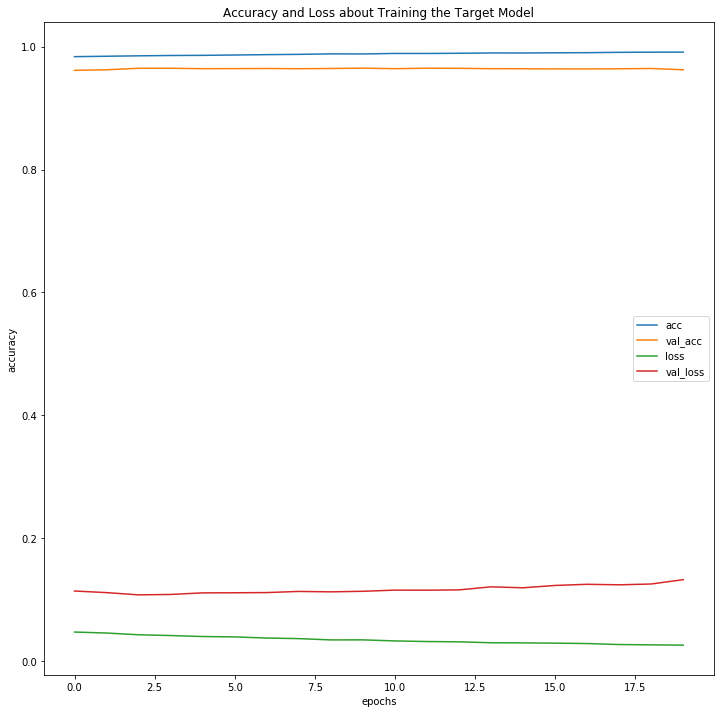

In [52]:
# visualize with graphics
hist = pd.DataFrame(histo_new.history)
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy and Loss about Training the Target Model")
# plt.show()
plt.legend()
plt.savefig('./outputs/Graphic_Val_accuracy_Training_Model_Target.png')      


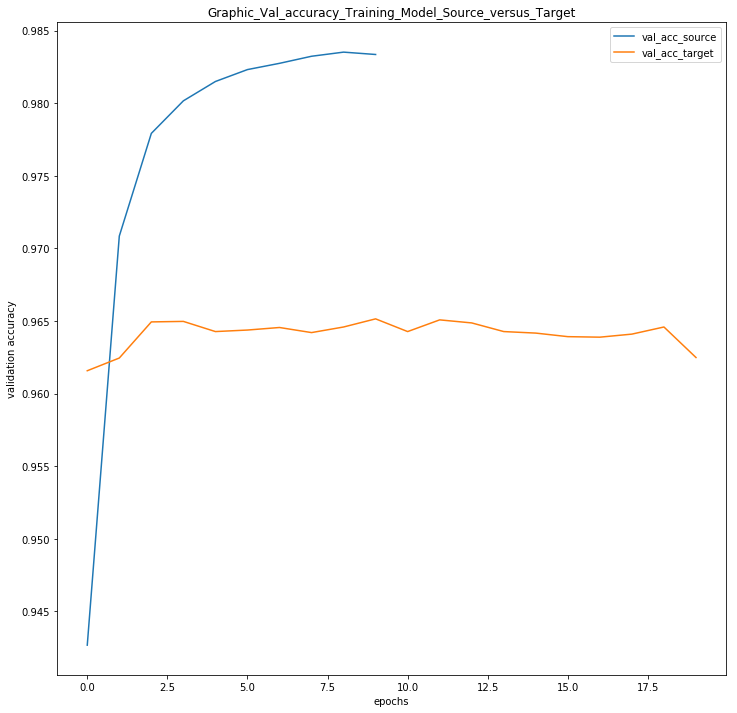

In [53]:
# histogram between transfer courbe and non-transfer curve
hist1 = pd.DataFrame(history.history)    # non-transfer
hist2 = pd.DataFrame(histo_new.history)     # with transfer
plt.figure(figsize=(12,12))
plt.plot(hist1["val_acc"], label='val_acc_source')
plt.plot(hist2["val_acc"], label='val_acc_target')
# plt.show()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.title('Graphic_Val_accuracy_Training_Model_Source_versus_Target')
plt.savefig('./outputs/Graphic_Val_accuracy_Training_Model_Source_versus_Target.png')    

In [54]:
print('\n>>> Make prediction of new classes')
test_preds_new = target_model.predict(X_test_new, verbose=2) #1

idx2tag_new = {i: w for w, i in tag2idx_new.items()}

# function to convert the prediction to label BIO
def pred2label_new(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag_new[p_i].replace("PAD", "O"))
#            out_i.append(idx2tag_new[p_i].replace("PAD", " ")) # by Tan, lundi 08/04/2019
        out.append(out_i)
    return out

# to convert prediction and test labels
pred_labels_new = pred2label_new(test_preds_new)
test_labels_new = pred2label_new(y_test_new)


>>> Make prediction of new classes


In [55]:
print("\n>>> F1-score: {:.2%}".format(flat_f1_score(test_labels_new, pred_labels_new, average='weighted')))


>>> F1-score: 96.34%


In [56]:
print('\n>>> Classification report:\n')
print(flat_classification_report(test_labels_new, pred_labels_new))


>>> Classification report:

              precision    recall  f1-score   support

           B       0.90      0.90      0.90      4658
           I       0.94      0.96      0.95      6832
           O       0.99      0.98      0.98     20210

   micro avg       0.96      0.96      0.96     31700
   macro avg       0.94      0.95      0.94     31700
weighted avg       0.96      0.96      0.96     31700



# Step 3: Prediction from the text file (testset)

In [57]:
# function readPredictSave(textFile) allows to predict the test file to path_output_col_prediction_target
def readPredictSave(textFile):
    # 1. Loading raw data from a text file
    rawdata = pd.read_csv(textFile, delimiter='\t',
                   header=None, 
                   encoding='utf-8', 
                   quoting=3  # means QUOTE_NONE
                   )
    
    rawdata = rawdata.rename(columns={0:'Sentence'}) #.drop_duplicates()

    # 2. Process
    words_rawdata = list(rawdata["Sentence"].values)
    
    compteur = 0 # compter les phrases
    # read from list of sentences
    for s in words_rawdata:
        resultX = []
        tokenized_rawdata = s.replace(" ", "")   
        temp = ''
        compteur += 1
        ### CACH 2
        # source: https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/
        x_test_sent = pad_sequences(sequences=[[word2idx_new.get(w, 0) for w in tokenized_rawdata]],
                                    padding="post", value=0, maxlen=max_len)
        
        
        print('\n>>> Make prediction of new classes')
        print('no_sent: ' + str(compteur))
        p = target_model.predict(np.array([x_test_sent[0]]))
        p = np.argmax(p, axis=-1)
        print("{:15}||{}".format("Word", "Prediction"))
        print(30 * "=")
        for w, pred in zip(tokenized_rawdata, p[0]):
            temp = "Sentence: " + str(compteur) + "\t" + w + "\t"+ tags[pred] #+ "\n"
            resultX.append(temp + "\n")
            print(temp)

        f_tempo.write(''.join(tok for tok in resultX) + "\n")

In [75]:
path_testset = config['path_testset'] 
path_output_col_prediction_target = config['path_output_col_prediction_target'] 

In [76]:
f_tempo = open(path_output_col_prediction_target, 'w', encoding="utf-8")

# call the function readPredictSave(textFile)
print('\n>>> Predicting from the test file...')
readPredictSave(path_testset)
print('\n...done') 
print('\n...saved to file path: ' + path_output_col_prediction_target)

f_tempo.close()


>>> Predicting from the test file...

>>> Make prediction of new classes
no_sent: 1
Word           ||Prediction
Sentence: 1	양	B
Sentence: 1	승	I
Sentence: 1	태	I
Sentence: 1	사	I
Sentence: 1	법	B
Sentence: 1	부	I
Sentence: 1	법	I
Sentence: 1	원	B
Sentence: 1	행	I
Sentence: 1	정	I
Sentence: 1	처	B
Sentence: 1	가	I
Sentence: 1	박	I
Sentence: 1	근	I
Sentence: 1	혜	B
Sentence: 1	전	I
Sentence: 1	대	B
Sentence: 1	통	I
Sentence: 1	령	B
Sentence: 1	의	I
Sentence: 1	세	I
Sentence: 1	월	O
Sentence: 1	호	I
Sentence: 1	7	I
Sentence: 1	시	I
Sentence: 1	간	B
Sentence: 1	행	I
Sentence: 1	적	B
Sentence: 1	관	I
Sentence: 1	련	B
Sentence: 1	명	I
Sentence: 1	예	B
Sentence: 1	훼	I
Sentence: 1	손	I
Sentence: 1	사	B
Sentence: 1	건	I
Sentence: 1	형	I
Sentence: 1	사	I
Sentence: 1	재	I
Sentence: 1	판	B
Sentence: 1	부	I
Sentence: 1	판	O
Sentence: 1	결	B
Sentence: 1	내	I
Sentence: 1	용	I
Sentence: 1	을	O
Sentence: 1	사	O
Sentence: 1	실	B
Sentence: 1	상	I
Sentence: 1	미	O

>>> Make prediction of new classes
no_sent: 2
Word           ||Prediction
Sentence: 2	

Sentence: 10	다	I
Sentence: 10	업	I
Sentence: 10	그	B
Sentence: 10	레	I
Sentence: 10	이	I
Sentence: 10	드	I
Sentence: 10	되	B
Sentence: 10	ㄴ	I
Sentence: 10	노	B
Sentence: 10	무	I
Sentence: 10	현	I
Sentence: 10	이	I
Sentence: 10	문	O

>>> Make prediction of new classes
no_sent: 11
Word           ||Prediction
Sentence: 11	소	B
Sentence: 11	방	B
Sentence: 11	차	I
Sentence: 11		I
Sentence: 11	에	I
Sentence: 11	길	B
Sentence: 11	안	I
Sentence: 11	비	I
Sentence: 11	키	I
Sentence: 11	어	I
Sentence: 11	주	I
Sentence: 11	면	B
Sentence: 11	과	I
Sentence: 11	태	B
Sentence: 11	료	I
Sentence: 11	왕	B
Sentence: 11	창	I
Sentence: 11	물	I
Sentence: 11	게	I
Sentence: 11	되	B
Sentence: 11	ㅂ	I
Sentence: 11	니	I
Sentence: 11	다	I
Sentence: 11	5	B
Sentence: 11	8	I
Sentence: 11	만	I
Sentence: 11	원	I
Sentence: 11	1	B
Sentence: 11	0	I
Sentence: 11	0	I
Sentence: 11	만	I
Sentence: 11	원	I

...done

...saved to file path: ./outputs/output_prediction_format_col.txt


In [73]:
path_output_col_prediction_target = config['path_output_col_prediction_target']
# 1 token (set of no_sentence, token, bio_tag) per line: 
# i.e. Sentence: 11    소       B

path_output_row_prediction_target = config['path_output_row_prediction_target']
# 1 sentence (set of lemmas) per line

In [79]:
# class SentenceGetter allows to deal with sentences from raw data
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        
        # with 2 columns: Word - Tag
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]

        
        # error: # bi loi cau thu 8 ???? ko lay lai data trung khop voi output_format.txt 
        # solution :: rajouter cette option sort=False dans groupby... garder l ordre du dataframe        
        #self.grouped = self.data.groupby("Sentence #").apply(agg_func)   # old version
        self.grouped = self.data.groupby("Sentence #", sort=False).apply(agg_func)  # new version

        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [77]:
### 1. Loading data
f_temp = open(path_output_row_prediction_target, 'w', encoding='utf-8')

# 1. Input : loading data
data = pd.read_csv(path_output_col_prediction_target, delimiter='\t',
                   header=None, 
                   encoding='utf-8', 
                   quoting=3  # means QUOTE_NONE
                   )

data = data.rename(columns={0:'Sentence #', 1:'Word', 2: 'Tag'}) 

data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
Sentence #    486 non-null object
Word          486 non-null object
Tag           486 non-null object
dtypes: object(3)
memory usage: 11.5+ KB


,Sentence #,Word,Tag
0,Sentence: 1,양,B
1,Sentence: 1,승,I
2,Sentence: 1,태,I
3,Sentence: 1,사,I
4,Sentence: 1,법,B
5,Sentence: 1,부,I
6,Sentence: 1,법,I
7,Sentence: 1,원,B
8,Sentence: 1,행,I
9,Sentence: 1,정,I


In [80]:
### 2. Process
getter = SentenceGetter(data)

# to regroup all sentences
sentences = getter.sentences

print("\n>>> 8th sentence looks like: ")
print(sentences[7]) 
print("\n>>> #sentences_in_col_format = ", len(sentences))  # all sentences for the test set

raw_data = [[(w,t) for w,t in s] for s in sentences]   # list of sentences


>>> 8th sentence looks like: 
[('김', 'I'), ('대', 'B'), ('중', 'I'), ('대', 'I'), ('통', 'I'), ('령', 'I'), ('의', 'B'), ('청', 'I'), ('렴', 'I'), ('도', 'I'), ('M', 'I'), ('B', 'I'), ('국', 'B'), ('정', 'I'), ('원', 'I'), ('D', 'I'), ('J', 'I'), ('비', 'I'), ('자', 'B'), ('금', 'I'), ('캐', 'I'), ('려', 'I'), ('고', 'I'), ('美', 'I'), ('국', 'B'), ('세', 'I'), ('청', 'I'), ('직', 'I'), ('원', 'I'), ('에', 'I'), ('뇌', 'I'), ('물', 'I'), ('저', 'I'), ('리', 'B'), ('털', 'I'), ('었', 'I'), ('는', 'B'), ('데', 'I'), ('아', 'B'), ('무', 'I'), ('것', 'I'), ('도', 'I'), ('안', 'I'), ('나', 'I'), ('오', 'I'), ('다', 'I'), ('니', 'O'), ('김', 'B'), ('대', 'I'), ('중', 'O')]

>>> #sentences_in_col_format =  11


Text(0, 0.5, '#examples')

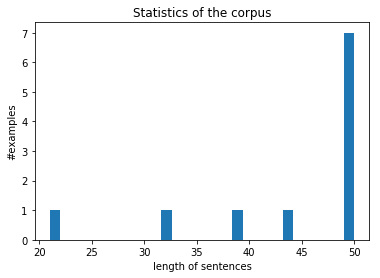

In [81]:
# visualize with graphics
plt.hist([len(s) for s in sentences], bins=30)
plt.title("Statistics of the corpus")
plt.xlabel('length of sentences')
plt.ylabel('#examples')
#plt.show()

In [82]:
count = 0  # variable to count all sentences

print('\n>>> Converting the column format into the row format...\n')
# loop
for sentence_tag in raw_data:
    count += 1
    #print(sentence_tag)  #list of tuple
    #if count == 1:
    #    break
    
    # loop for all words in 1 sentence :: list of tuple
    prev_tag = "O" # flag
    tempo = ""
    for token, tag in sentence_tag:      
        if tag == "O": # for tag O
            tempo += " " + token #+ "_O "
            prev_tag = tag
            continue
        if tag != "O" and prev_tag == "O": # begin B
            tempo += " " + token #+ "_B "
            prev_tag = tag
        elif prev_tag != "O" and tag == "I": # inside I
            tempo += token #+ "_I "
            prev_tag = tag
        elif prev_tag != "O" and tag != "I": # adjacent B
            tempo += " " + token #+ "_B "
            prev_tag = tag
    
    print('#' + str(count) + ': ' + tempo.strip())

	# write a newline
    f_temp.write(tempo.strip() + "\n")

print('\n...done')
print('\n...saved to file path: ' + path_output_row_prediction_target)   


>>> Converting the column format into the row format...

#1: 양승태사 법부법 원행정 처가박근 혜전 대통 령의세 월 호7시 간행 적관 련명 예훼손 사건형사재 판부 판 결내용 을 사 실상 미
#2: "이재명이대로괜찮 은걸 ㄹ까요오늘도국민청 원 달리ㅂ니다 불법폭 력조 직 코 마트레이 드와 연루 되ㄴ성 남 시장은수 미
#3: Goodm orn in gTw itt erw orldJustf iv em in ut es
#4: 이상하게 얘기하 면나바로 끊어버 리ㄹ 거야 잘 안들리ㅂ니다 예의 가 없어 예의 가안되어 예의 가 없어 예의 가
#5: 주진우가이랬어었단 말이 지하나쁘ㄴ놈이네‼‼
#6: 김 종필 문재인이 대통 령되 면김정 은이만나 러갈 ㄴ다니 빌 어먹 을자 식육성인터뷰공개 용서이라 는것은말이지요사람 에
#7: 김종 필훈 장 추서 반대국민청원사 람이죽으면 애도하어야맞습니 다그러나박정 희와 함께오늘날 일어나 ㄴ한국사회적 폐
#8: 김 대중대통령 의청렴도MB 국정원DJ비 자금캐려고美 국세청직원에뇌물저 리털었 는데 아무것도안나오다 니 김대 중
#9: 인을가 지ㄴ사 람만이통 치하는 위치에있어야 하며인 을갖추 지못하ㄴ 사람이통 치하는 위치에있으 면그좋 지못 하 ㄴ 행위
#10: 문파초짜 들 은이것만 기 억하시 면되ㅂ니다 15 년전과달라지ㄴ건문 재인과문파이ㅂ니다업 그레이드 되ㄴ 노무현이 문
#11: 소 방차에 길안비키어주 면과 태료 왕창물게 되ㅂ니다 58만원 100만원

...done

...saved to file path: ./outputs/output_prediction_format_row.txt


In [83]:
### 3. Output display
print("\n>>> #sentences_in_row_format = " + str(count))

f_temp.close()


>>> #sentences_in_row_format = 11


In [84]:
print("="*50)
print("FINISH WITH SUCCESSFUL.")
print("="*50)

FINISH WITH SUCCESSFUL.
